
# **나의 해방일지**

---

# 12월 15일 <br>

Stage 3: inference<br><br>
첫째 작업: 나의 구글 드라이브에 있는 이미지를 불러와 testloader에 이미지와 라벨을 저장하였다.
<br><br>
발생된 문제 1: 데이터셋을 batch별로 나눌 때, 각 이미지의 사이즈가 같아야 하기 때문에, "stack expects each tensor to be equal size" 에러가 나왔다. 

문제 해결 방법 1: transform에서 transforms.Resize 코드를 추가하여 MNIST와 같은 사이즈 (28,28)로 변환하였다.
<br><br>
결론: 손글씨 데이터셋으로 평가해본 결과, 특정 숫자의 경우는 잘 맞추었지만 나머지 숫자에 있어서는 숫자 판별을 제대로 하지  못하였다. 

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms 
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%config InlineBackend.figure_format='retina'

In [ ]:
torch.manual_seed(316)

In [ ]:
from collections import OrderedDict 

class Network(nn.Module): 

  def __init__(self):
    super().__init__()
    self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 512, kernel_size=7,stride = 1, padding=3), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride =1,padding= 1),
            nn.Conv2d(512, 256, kernel_size=3,stride = 1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3,stride = 1, padding=1), 
            nn.Conv2d(128, 64, kernel_size=3,stride = 1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3,stride = 1, padding=1),
            nn.Conv2d(32, 100, kernel_size=3,stride = 1, padding=1),
            nn.Conv2d(100, 200, kernel_size=3,stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5,  stride =1)
            )
    self.classifier = nn.Sequential(
            nn.Linear(22*22*200, 2048), 
            nn.BatchNorm1d(2048), 
            nn.Dropout(p=0.5), 
            nn.ReLU(),
            nn.Linear(2048, 10)
            )
    
  def forward(self, x: torch.Tensor) -> torch.Tensor: 
    out1 = self.feature_extraction(x)
    out2 = torch.flatten(out1, 1)
    out3 = self.classifier(out2)
    return out3 

model = Network()

In [ ]:
model.load_state_dict(
    torch.load("/content/drive/MyDrive/model_1209.pth", map_location=torch.device("cpu"))
)
model.eval()

Network(
  (feature_extraction): Sequential(
    (0): Conv2d(1, 512, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(32, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=96800, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
from torchsummary import summary 
summary(model, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 28, 28]          25,600
              ReLU-2          [-1, 512, 28, 28]               0
         MaxPool2d-3          [-1, 512, 26, 26]               0
            Conv2d-4          [-1, 256, 26, 26]       1,179,904
              ReLU-5          [-1, 256, 26, 26]               0
            Conv2d-6          [-1, 128, 26, 26]         295,040
            Conv2d-7           [-1, 64, 26, 26]          73,792
              ReLU-8           [-1, 64, 26, 26]               0
            Conv2d-9           [-1, 32, 26, 26]          18,464
           Conv2d-10          [-1, 100, 26, 26]          28,900
           Conv2d-11          [-1, 200, 26, 26]         180,200
             ReLU-12          [-1, 200, 26, 26]               0
        MaxPool2d-13          [-1, 200, 22, 22]               0
           Linear-14                 [-

In [ ]:
img_mean = [0.1307]
img_std = [0.3081]

transform = transforms.Compose(
  [
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std),
] )

In [ ]:
data_dir = "/content/drive/MyDrive/E02_data"
batch_size = 1

testset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [ ]:
idx_to_class = { v:k for k, v in testset.class_to_idx.items() } 
idx_to_class

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

In [ ]:
image, label_correct = testloader.dataset[0]

In [ ]:
label_correct = idx_to_class[label_correct]
label_correct

'0'

In [ ]:
image.shape

torch.Size([1, 28, 28])

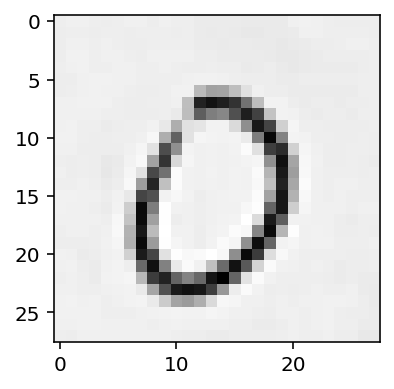

In [ ]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [ ]:
top_probs.squeeze().numpy()

array([9.9343598e-01, 5.3294580e-03, 1.0485427e-03, 9.5698466e-05,
       4.5162134e-05, 3.1876541e-05, 7.0965402e-06, 4.9229388e-06,
       9.8953069e-07, 2.9265010e-07], dtype=float32)

In [ ]:
top_classes.squeeze().numpy()

array([1, 0, 6, 9, 4, 5, 8, 2, 7, 3])

In [ ]:
label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'1'

Predicted : 1
Ground Truth : 0


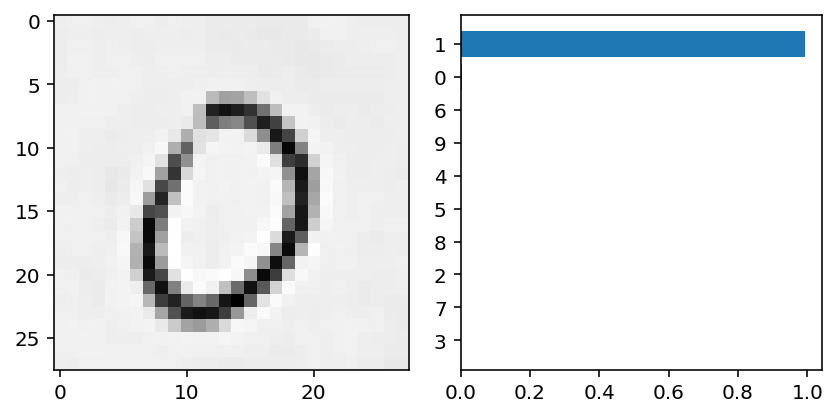

Accuracy: 0.005


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 0]), 3))

In [ ]:
image, label_correct = testloader.dataset[25]

In [ ]:
label_correct = idx_to_class[label_correct]
label_correct

'1'

In [ ]:
image.shape

torch.Size([1, 28, 28])

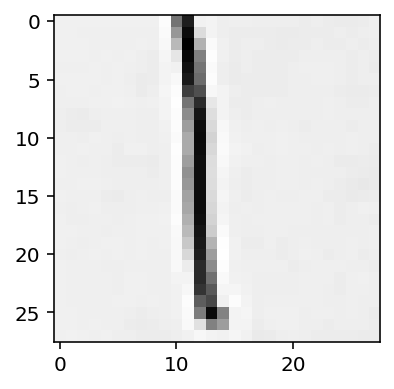

In [ ]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [ ]:
top_probs.squeeze().numpy()

array([9.8785257e-01, 9.7443117e-03, 2.3304552e-03, 6.6404944e-05,
       3.5694334e-06, 1.9377378e-06, 3.8906589e-07, 2.3829479e-07,
       2.0937190e-07, 6.0271332e-10], dtype=float32)

In [ ]:
top_classes.squeeze().numpy()

array([1, 0, 4, 6, 9, 5, 7, 8, 2, 3])

In [ ]:
label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'1'

Predicted : 1
Ground Truth : 1


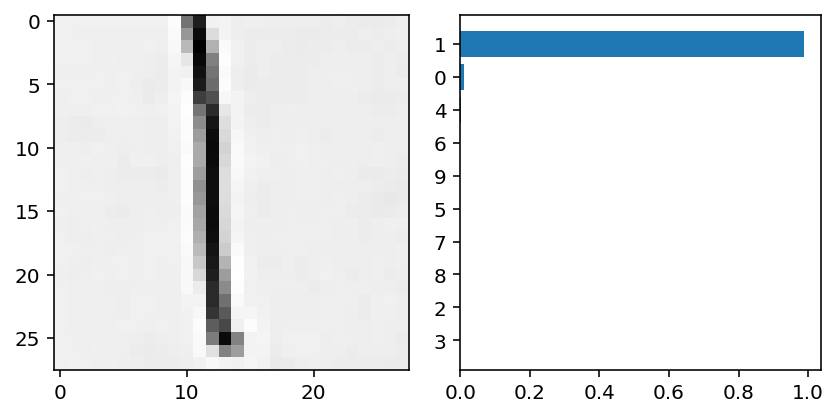

Accuracy: 0.988


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 1]), 3))

In [ ]:
image, label_correct = testloader.dataset[50]

In [ ]:
label_correct = idx_to_class[label_correct]
label_correct

'2'

In [ ]:
image.shape

torch.Size([1, 28, 28])

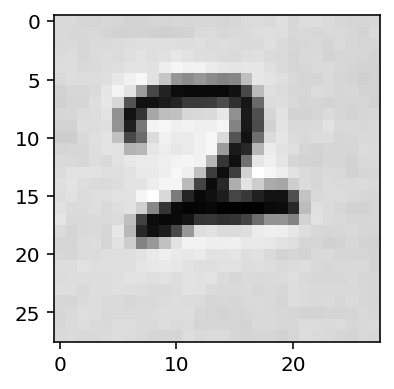

In [ ]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [ ]:
top_probs.squeeze().numpy()

array([7.5914937e-01, 1.0583867e-01, 5.7521623e-02, 5.6567263e-02,
       1.0206731e-02, 6.4943177e-03, 3.7664375e-03, 2.2034399e-04,
       1.8393301e-04, 5.1387386e-05], dtype=float32)

In [ ]:
top_classes.squeeze().numpy()

array([2, 7, 0, 1, 3, 5, 9, 8, 6, 4])

In [ ]:
label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'2'

Predicted : 2
Ground Truth : 2


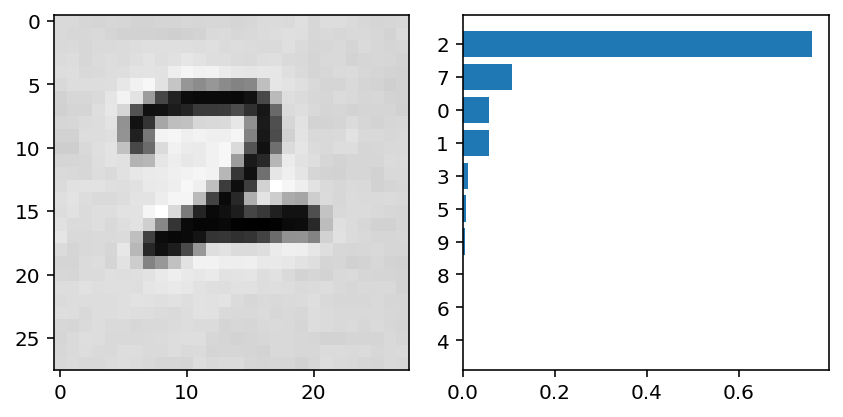

Accuracy: 0.759


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 2]), 3))

In [ ]:
image, label_correct = testloader.dataset[75]

In [ ]:
label_correct = idx_to_class[label_correct]
label_correct

'3'

In [ ]:
image.shape

torch.Size([1, 28, 28])

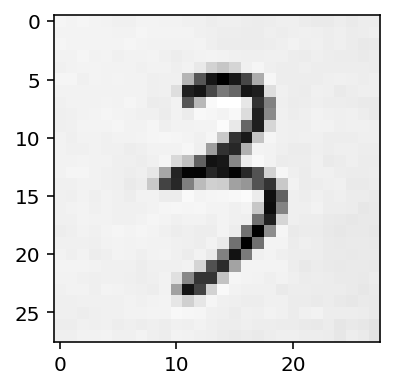

In [ ]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [ ]:
top_probs.squeeze().numpy()

array([4.4356963e-01, 4.4150683e-01, 7.1628131e-02, 1.6238259e-02,
       1.2068608e-02, 7.6501598e-03, 2.8284157e-03, 2.7192514e-03,
       1.4810766e-03, 3.0968155e-04], dtype=float32)

In [ ]:
top_classes.squeeze().numpy()

array([0, 1, 6, 2, 9, 8, 7, 4, 5, 3])

In [ ]:
label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'0'

Predicted : 0
Ground Truth : 3


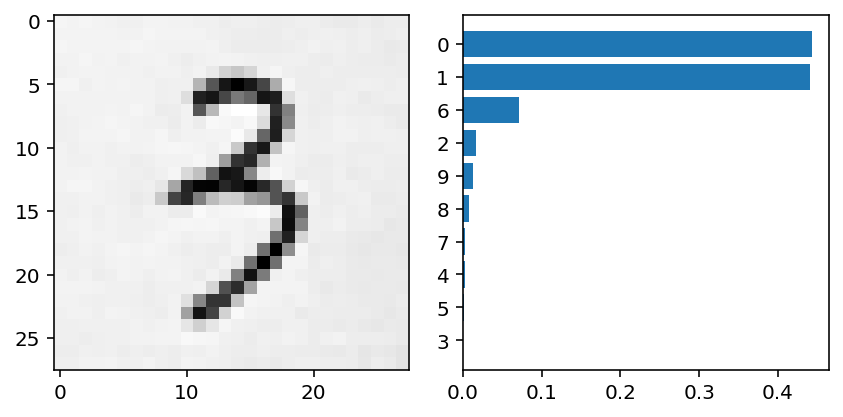

Accuracy: 0.0


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 3]), 3))